In [1]:
from pathlib import Path
from src import config

In [9]:
dataset_filepath = Path("../..").resolve() / config.datasets.tiny_shakespeare.folder / Path(config.datasets.tiny_shakespeare.url).name
dataset_filepath


PosixPath('/Users/andreiaksionov/Study/Machine_Learning/my_repositories/nanoGPT/data/raw/tiny_shakespeare/input.txt')

In [14]:
with open(dataset_filepath, "r") as fin:
    dataset = fin.read()

In [18]:
print(dataset[:3_00])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [20]:
dataset[:1_000].split("\n\n")

['First Citizen:\nBefore we proceed any further, hear me speak.',
 'All:\nSpeak, speak.',
 'First Citizen:\nYou are all resolved rather to die than to famish?',
 'All:\nResolved. resolved.',
 'First Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.',
 "All:\nWe know't, we know't.",
 "First Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?",
 "All:\nNo more talking on't; let it be done: away, away!",
 'Second Citizen:\nOne word, good citizens.',
 'First Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this 

### Characters

In [30]:
from collections import Counter
counter = Counter([x.split("\n")[0][:-1] for x in dataset.split("\n\n")])

In [31]:
len(counter)

310

In [32]:
counter.most_common(10)

[('GLOUCESTER', 229),
 ('DUKE VINCENTIO', 193),
 ('ROMEO', 163),
 ('MENENIUS', 162),
 ('PETRUCHIO', 158),
 ('CORIOLANUS', 149),
 ('KING RICHARD III', 138),
 ('ISABELLA', 129),
 ('JULIET', 125),
 ('LEONTES', 125)]

### Texts

In [45]:
texts = []
for block in dataset.split("\n\n"):
    if not block:
        continue
    block_split = block.split(":", maxsplit=1)
    if len(block_split) != 2:
        print("!!!")
        print(block)
        print(block_split)
        break
    texts.append(block_split[1][1:])

In [47]:
texts[:10]

['Before we proceed any further, hear me speak.',
 'Speak, speak.',
 'You are all resolved rather to die than to famish?',
 'Resolved. resolved.',
 'First, you know Caius Marcius is chief enemy to the people.',
 "We know't, we know't.",
 "Let us kill him, and we'll have corn at our own price.\nIs't a verdict?",
 "No more talking on't; let it be done: away, away!",
 'One word, good citizens.',
 'We are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger for bread, not in thirst for revenge.']

In [50]:
from matplotlib import pyplot as plt
import numpy as np

In [49]:
text_length = [len(x) for x in texts]

0 3068 141.33979507061755


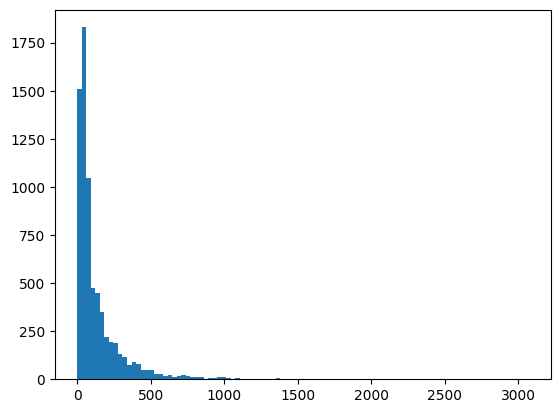

In [55]:
print(min(text_length), max(text_length), np.mean(text_length))

plt.hist(text_length, bins=100);

In [56]:
text_length_words = [len(x.split(" ")) for x in texts]

1 506 24.16394350595403


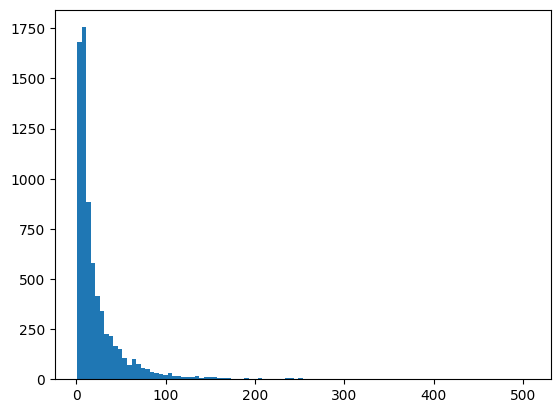

In [57]:
print(min(text_length_words), max(text_length_words), np.mean(text_length_words))

plt.hist(text_length_words, bins=100);

In [71]:
word_counter = Counter()
for text in texts:
    word_counter.update(text.split(" "))
print(len(word_counter))
word_counter.most_common(20)

37176


[('the', 5261),
 ('to', 3830),
 ('I', 3672),
 ('and', 3532),
 ('of', 3195),
 ('my', 2644),
 ('a', 2517),
 ('you', 2016),
 ('in', 2014),
 ('that', 1737),
 ('is', 1720),
 ('not', 1547),
 ('with', 1506),
 ('your', 1450),
 ('be', 1434),
 ('for', 1340),
 ('his', 1338),
 ('have', 1224),
 ('it', 1131),
 ('he', 1095)]